# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import scrnatools as rna
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind

In [3]:
# Setup figure params
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"
sc.set_figure_params(dpi=80, dpi_save=600, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["axes.grid"] = False
cmap = sns.color_palette("colorblind")

In [4]:
warnings.resetwarnings()

## Set up file paths

### demeter

In [5]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

### gardner-lab-computer

In [6]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

## Import data

In [7]:
adata = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/combined_all_genes_TECs_final.h5ad")

In [8]:
adata.obs.genotype.value_counts()

WT          22993
Aire_KO     14448
Fezf2_KO    12951
Name: genotype, dtype: int64

# Differential Density

In [10]:
target_cells = 12951

adatas = [adata[adata.obs.genotype.isin([genotype])] for genotype in adata.obs.genotype.cat.categories]

for dat in adatas:
    if dat.n_obs > target_cells:
         sc.pp.subsample(dat, n_obs=target_cells)

adata_downsampled = adatas[0].concatenate(*adatas[1:])

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


## Fezf2 KO

In [11]:
adata_downsampled = rna.tl.log_density_ratio(
    adata_downsampled,
    group_by="genotype",
    groups=["WT", "Fezf2_KO"],
    key_added="Fezf2_KO/WT_genotype_density",
    latent_rep="X_umap",
)

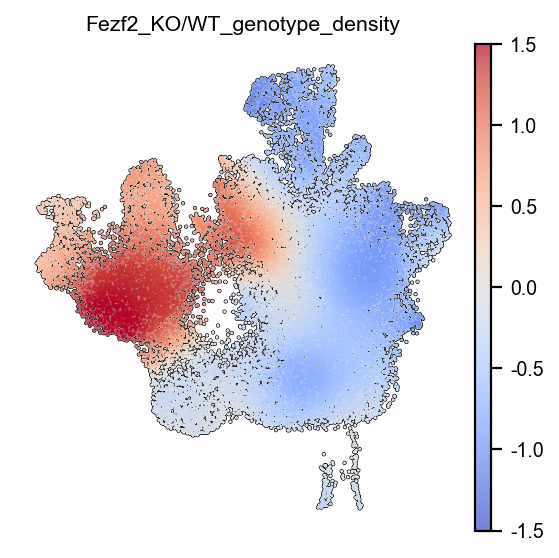

In [12]:
sc.settings.figdir = "../../analysis/paper_figures/1/"
sc.pl.umap(
    adata_downsampled,
    color="Fezf2_KO/WT_genotype_density",
    cmap="coolwarm",
    vmin=-1.5,
    vmax=1.5,
    save="_1D_Fezf2_KO_density.pdf",
    add_outline=True,
    s=5
)

## Aire KO

In [13]:
adata_downsampled = rna.tl.log_density_ratio(
    adata_downsampled,
    group_by="genotype",
    groups=["WT", "Aire_KO"],
    key_added="Aire_KO/WT_genotype_density",
    latent_rep="X_umap",
)

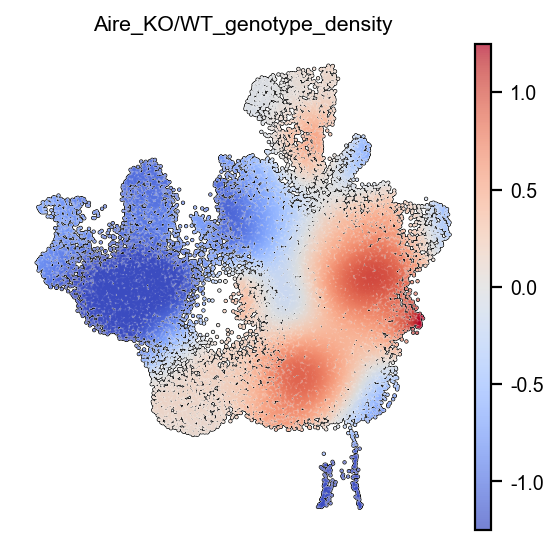

In [16]:
sc.settings.figdir = "../../analysis/paper_figures/1/"
sc.pl.umap(
    adata_downsampled,
    color="Aire_KO/WT_genotype_density",
    cmap="coolwarm",
    vmin=-1.25,
    vmax=1.25,
    save="_1D_Aire_KO_density.pdf",
    add_outline=True,
    s=5
)

# Cell type abundance

In [12]:
abundance_data = pd.DataFrame()
for genotype in adata.obs.genotype.unique():
    genotype_data = adata[adata.obs.genotype == genotype]
    for sample in genotype_data.obs["sample"].unique():
        sample_data = genotype_data[genotype_data.obs["sample"] == sample]
        cell_type_abundances = sample_data.obs.subclustered.value_counts()
        cell_type_abundances = cell_type_abundances/sample_data.shape[0]*100
        cell_type_abundances = pd.DataFrame(cell_type_abundances)
        cell_type_abundances = cell_type_abundances.reset_index()
        cell_type_abundances.columns = ["cell_type", "abundance"]
        cell_type_abundances["genotype"] = genotype
        cell_type_abundances["sample"] = sample
        abundance_data = pd.concat([abundance_data, cell_type_abundances], ignore_index=True)

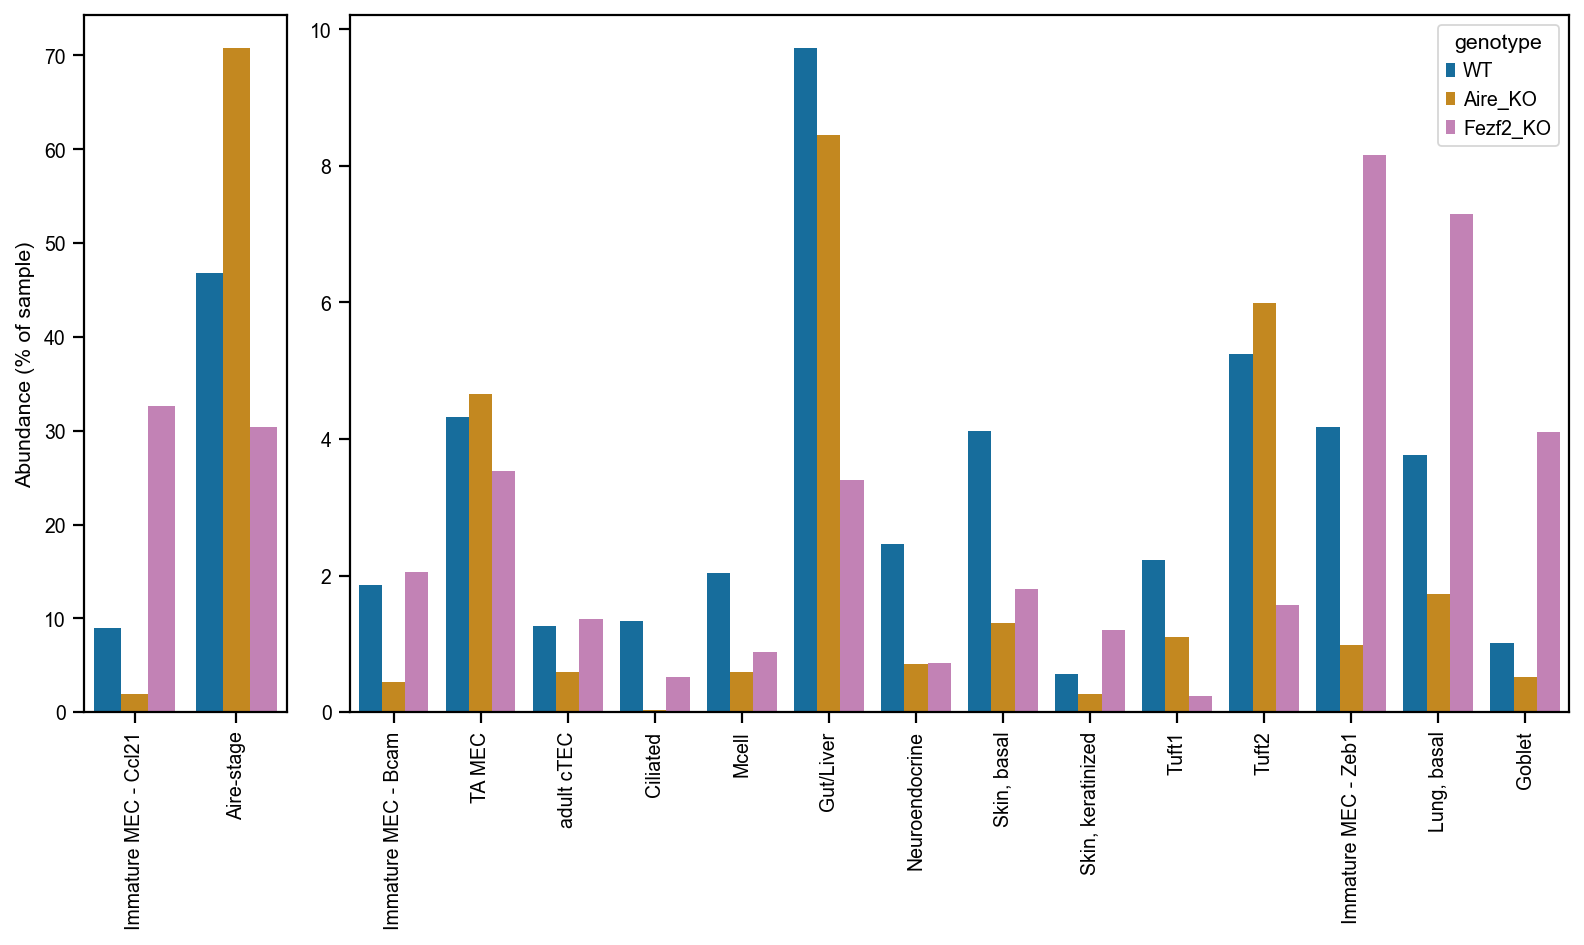

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/tmp/tmp1rq_p53e'>
  _warnings.warn(warn_message, ResourceWarning)


In [23]:
fig, axs = plt.subplots(1,2,figsize=(10,6), gridspec_kw={'width_ratios': [1, 6]})

sns.barplot(
    abundance_data[abundance_data.cell_type.isin(["Aire-stage", "Immature MEC - Ccl21"])],
    x="cell_type",
    y="abundance",
    hue="genotype",
    ax=axs[0],
    # errorbar=("pi", 100),
    errorbar=None,
    order = ["Immature MEC - Ccl21", "Aire-stage"],
    palette=cmap[0:2] + [cmap[4]],
)
axs[0].get_legend().remove()
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[0].set_xlabel("")
axs[0].set_ylabel("Abundance (% of sample)")
axs[0].grid(False)

sns.barplot(
    abundance_data[~abundance_data.cell_type.isin(["Aire-stage", "Immature MEC - Ccl21"])],
    x="cell_type",
    y="abundance",
    hue="genotype",
    ax=axs[1],
    # errorbar=("pi", 100),
    errorbar=None,
    order = [
        "Immature MEC - Bcam", "TA MEC", "adult cTEC", "Ciliated", "Mcell", 
        "Gut/Liver", "Neuroendocrine", "Skin, basal", "Skin, keratinized",
        "Tuft1", "Tuft2", "Immature MEC - Zeb1", "Lung, basal", "Goblet",
    ],
    palette=cmap[0:2] + [cmap[4]],
)
axs[1].set_ylabel("")
axs[1].set_xlabel("")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[1].grid(False)

plt.subplots_adjust(wspace=0.15)
plt.tight_layout()
plt.savefig("../../analysis/paper_figures/1/1E_scRNAseq_cell_type_abundances.pdf")
plt.show()

In [14]:
pvalues = pd.DataFrame()
for cell_type in abundance_data.cell_type.unique():
    cell_type_data = abundance_data[abundance_data.cell_type == cell_type]
    WT_abundance = cell_type_data[cell_type_data.genotype == "WT"].abundance
    for genotype in "Aire_KO", "Fezf2_KO":
        KO_abundance = cell_type_data[cell_type_data.genotype == genotype].abundance
        pvalue = pd.DataFrame(
            [cell_type, genotype, ttest_ind(WT_abundance, KO_abundance).pvalue],
            index=["cell_type", "genotype", "pval"]
        ).T
        pvalues = pd.concat([pvalues, pvalue], ignore_index=True)
pvalues

,cell_type,genotype,pval
0,Aire-stage,Aire_KO,0.035829
1,Aire-stage,Fezf2_KO,0.085937
2,Immature MEC - Ccl21,Aire_KO,0.128111
3,Immature MEC - Ccl21,Fezf2_KO,0.05202
4,Gut/Liver,Aire_KO,0.492544
5,Gut/Liver,Fezf2_KO,0.005502
6,Tuft2,Aire_KO,0.588848
7,Tuft2,Fezf2_KO,0.030177
8,TA MEC,Aire_KO,0.869048
9,TA MEC,Fezf2_KO,0.404661
